In [ ]:
import shutil,timm,os,torch,random,datasets,math
import fastcore.all as fc, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
#import k_diffusion as K,
import torchvision.transforms as T
import torchvision.transforms.functional as TF,torch.nn.functional as F

from torch.utils.data import DataLoader,default_collate
from pathlib import Path
from torch.nn import init
from fastcore.foundation import L
from torch import nn,tensor
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy
from functools import partial
from torch.optim import lr_scheduler
from torch import optim
from torchvision.io import read_image,ImageReadMode
from glob import glob

In [ ]:
from n_framework import*
from activations_module import *
from fastprogress import progress_bar

In [ ]:
torch.set_printoptions(precision=5, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['figure.dpi'] = 70

set_seed(42)


In [ ]:
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path = path_data/'tiny-imagenet-200'

url = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'

In [ ]:
# unpack and download the zip file, 

# if not path.exists():
#     path_zip = fc.urlsave(url, path_data)
#     shutil.unpack_archive('data/tiny-imagenet-200.zip', 'data')    

In [ ]:
bs = 512

## Preprocessing data

In [ ]:
class Tiny_dataset:
    def __init__(self, path):
        self.path = Path(path)
        self.files = glob(str(path/'**/*.JPEG'), recursive=True)
    def __len__(self): return len(self.files)
    def __getitem__(self, i ): return self.files[i], Path(self.files[i]).parent.parent.name
    
tds = Tiny_dataset(path/'train')

In [ ]:
tds[0]

('data/tiny-imagenet-200/train/n02795169/images/n02795169_369.JPEG',
 'n02795169')

In [ ]:
path_anno = path/'val'/'val_annotations.txt'
path_anno

Path('data/tiny-imagenet-200/val/val_annotations.txt')

In [ ]:
path_search = path/'train/'
path_search

Path('data/tiny-imagenet-200/train')

In [ ]:
anno = dict(o.split('\t')[:2] for o in path_anno.read_text().splitlines())

In [ ]:
class TinyValDs(Tiny_dataset):
    def __getitem__(self, i): return self.files[i], anno[os.path.basename(self.files[i])]

In [ ]:
vds = TinyValDs(path/'val')

In [ ]:
vds[0]

('data/tiny-imagenet-200/val/images/val_506.JPEG', 'n02977058')

In [ ]:
len(vds)

10000

In [ ]:
class TfmDS:
    def __init__(self, ds, tfmx = fc.noop, tfmy= fc.noop): self.ds, self.tfmx, self.tfmy = ds, tfmx, tfmy
    def __len__(self): return len(self.ds)
    def __getitem__(self, i):
        x,y = self.ds[i]
        return self.tfmx(x), self.tfmy(y)

In [ ]:
id2st = (path/'wnids.txt').read_text().splitlines()
st2ids = {v:k for k,v in enumerate(id2st) }
len(st2ids)

200

In [ ]:
xmean,xstd = (tensor([0.47565, 0.40303, 0.31555]), tensor([0.28858, 0.24402, 0.26615]))

In [ ]:
# normalizing
def tfmx(x):
    img = read_image(x, mode= ImageReadMode.RGB)/255 # we get num between 0 and 1
    return (img - xmean[:, None,None])/xstd[:, None, None]  # adding unit indexes,with None fro broadcasting

In [ ]:
def tfmy(y): return tensor(st2ids[y])

In [ ]:
tfm_tds = TfmDS(tds, tfmx, tfmy)
tfm_vds = TfmDS(vds, tfmx, tfmy)

In [ ]:
xi, yi = tfm_tds[0]
id2st[yi]
#st2ids['n04560804']

'n02795169'

In [ ]:
xi.shape, yi.shape

(torch.Size([3, 64, 64]), torch.Size([]))

In [ ]:
# denormalzing the normalized image, jsut as we divided the image with std we multiply it to denorm and add back xmean
def denorm(x): return (x*xstd[:,None,None] + xmean[:, None,None]).clip(0,1)

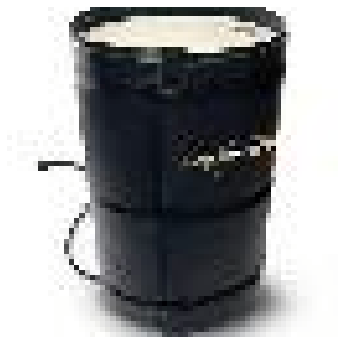

In [ ]:
show_image(denorm(xi));

In [ ]:
dltrn = DataLoader(tfm_tds, batch_size=bs, shuffle=True)

In [ ]:
xb, yb = b = next(iter(dltrn))

In [ ]:
xb.shape

torch.Size([512, 3, 64, 64])

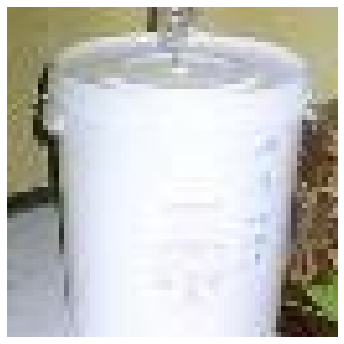

In [ ]:
show_image(denorm(xb[118]));

In [ ]:
all_synsets = [o.split('\t') for o in (path/'words.txt').read_text().splitlines()]
synsets = {k:v.split(',', maxsplit=1)[0] for k,v in all_synsets if k in id2st}

In [ ]:
titles = [synsets[id2st[o]] for o in yb]
', '.join(titles[:20])

"meat loaf, cliff dwelling, sandal, moving van, sports car, parking meter, drumstick, sock, torch, coral reef, cockroach, sock, sea cucumber, potter's wheel, cliff, mantis, cliff dwelling, go-kart, refrigerator, walking stick"

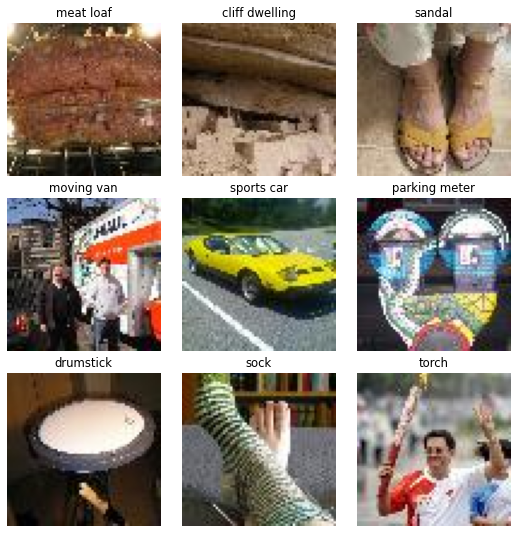

In [ ]:
show_images(denorm(xb[:9]), titles=titles[:9], imsize=2.5)

In [ ]:
dls = DataLoaders(*get_dls(tfm_tds, tfm_vds, bs =bs))

## basic model

In [ ]:
def tfm_batch(b, tfm_x=fc.noop, tfm_y=fc.noop): return tfm_x(b[0], tfm_y(b[1]))

In [ ]:
tfms = nn.Sequential(T.Pad(4), T.RandomCrop(64),
                    T.RandomHorizontalFlip(),
                    RandErase())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x = tfms), val on_val =False)

In [ ]:
BatchTransformCB??